In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using Zygote, Lux, LuxCUDA, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib, JLD2
using Random: Xoshiro
using MLUtils: DataLoader

In [3]:
using PhasorNetworks

# Load the dataset

In [4]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [5]:
using Base: @kwdef

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128, epochs = 25)

Args(0.0003, 128, 25, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [12]:
q |> size

(20, 13, 21, 99991)

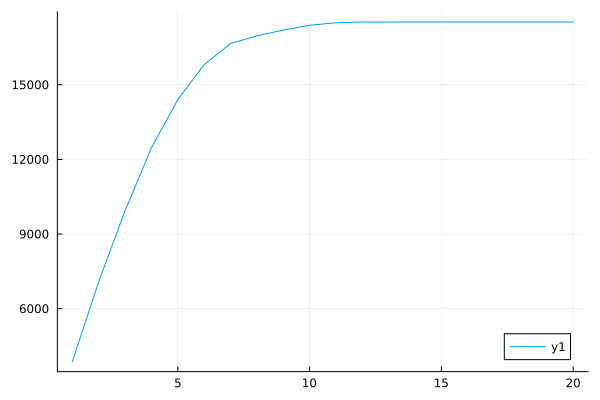

In [13]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

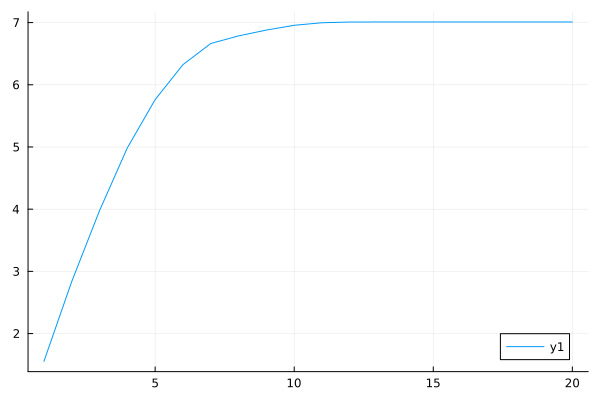

In [14]:
plot(sum(scale_charge(q[:,:,:,128]), dims=(2,3)) |> vec)

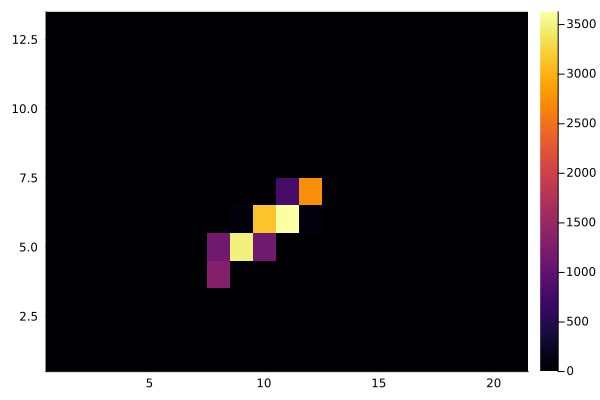

In [15]:
heatmap(q[12,:,:,128])

In [16]:
ylocal |> size

(99991,)

In [17]:
pt |> size

(99991,)

In [18]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [19]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [21]:
x |> size

(20, 13, 21, 128)

In [22]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [23]:
function process_inputs(x, y_local)
    x = scale_charge(x[end,:,:,:])
    x = sum(x, dims=(2))
    n_batch = size(x, 3)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [24]:
process_inputs(x, xl)

14×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.252     0.0004    0.0         0.0      0.03       0.0
  0.3008    1.4032    0.3624    0.6752      0.0      2.9176     0.5328
  0.8116    1.6196    0.89      2.6088      0.0      4.998      2.304
  1.0256    1.5404    1.2096    2.2608   …  1.1748   2.0668     2.768
  0.9528    0.6404    1.2876    3.8688      2.752    0.0        1.4048
  0.6928    0.0       0.464     0.0         0.0132   0.0        0.0
  0.4444    0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
 -6.94104  -4.33669  -7.79379  -2.67448     3.28174  0.134332  -1.43261

In [25]:
model = Chain(
    LayerNorm((n_in,)),
    x -> tanh.(x),
    PhasorDenseF32(n_in => 128),
    PhasorDenseF32(128 => 3) 
)

Chain(
    layer_1 = LayerNorm((14,), affine=true, dims=Colon()),  # 28 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#48#49"()),
    layer_3 = PhasorDenseF32((14, 128)),  # 2_048 parameters
    layer_4 = PhasorDenseF32((128, 3)),  # 390 parameters
)         # Total: 2_466 parameters,
          #        plus 0 states.

In [26]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.012532993 0.13751148 … 0.005174529 -0.1467415; -0.10304676 0.08072104 … 0.08704694 -0.1512706; … ; 0.11642004 -0.1825578 … -0.119460106 -0.06416814; 0.056921583 -0.09566052 … 0.085579105 -0.20602593], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_4 = (weight = Float32[0.10452084 0.07265444 … -0.038100667 0.05980781; -0.022380695 -0.15790255 … 0.04576584 0.037232745; 0.05314552 -0.14570683 … -0.1345809 0.32224092], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [27]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([0.6278206768557522 0.6140393627600826 … 0.5590198737543738 0.6971272777564801; -0.8315125046151566 -0.7216165706364751 … -0.8084206900946485 -0.6837124471853254; 0.039007524036571525 0.05054780850672449 … 0.03904203121002562 0.0570851597657657], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [28]:
y_naive |> size

(3, 128)

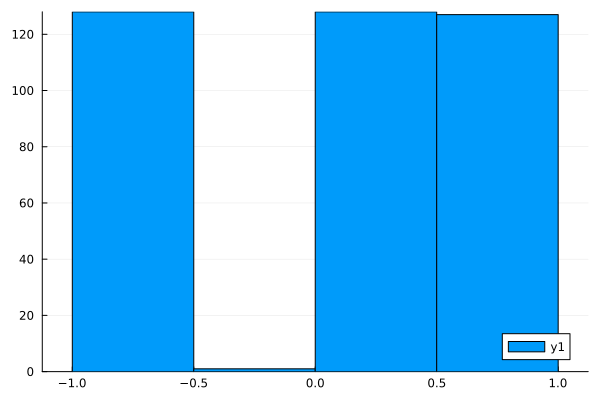

In [29]:
histogram(y_naive |> vec)

In [30]:
using Statistics: std, median, mean

In [31]:
using OneHotArrays

In [32]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [33]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [34]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [35]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [36]:
l0, st0 = @time loss(x, xl, y, model, ps, st, 0.2)

  0.147290 seconds (566.75 k allocations: 40.827 MiB, 99.43% compilation time)


(1.2392116715942327, (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [37]:
l0

1.2392116715942327

In [38]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        #epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
            append!(losses, loss_val)
        end
        
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [39]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 25)

[ Info: Constructing model and starting training


 95.862912 seconds (45.50 M allocations: 335.407 GiB, 22.78% gc time, 11.37% compilation time)


(Any[1.2392116715942327, 1.1475163111865978, 1.1374461003502898, 1.069632325342715, 1.0875455829814786, 0.9983323222444228, 1.0031505262666802, 0.936107314799034, 0.9421584949258022, 0.9434758122062048  …  0.1465400042618464, 0.14590938842710485, 0.13792569596217527, 0.12989593179253903, 0.1676438614562219, 0.18930568188966082, 0.19207176021100827, 0.16161923755728624, 0.16948143957834716, 0.21739242651304214], (layer_1 = (bias = Float32[0.16273057; 0.14440632; … ; 0.10742548; 0.16017902;;], scale = Float32[0.90953684; 1.0211077; … ; 0.9692952; 0.21330272;;]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.04875535 0.14249757 … -0.038562097 -0.010224231; -0.09538682 0.055546932 … 0.08666169 -0.13083732; … ; 0.060993683 -0.1943256 … -0.14058949 -0.04987742; 0.06572805 -0.0921352 … 0.07670456 0.008203546], bias_real = Float32[1.0450779, 1.0433798, 0.87564456, 1.1127546, 0.9772583, 0.90720046, 0.92032915, 0.9411631, 0.7063748, 1.0286107  …  0.9180639, 0.93802494, 0.98018193, 1.020

In [40]:
sttf = Lux.testmode(stt)

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

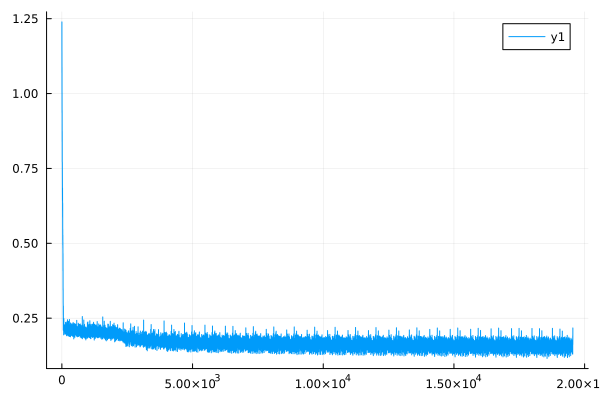

In [41]:
plot(loss_history)

In [42]:
loss(x, xl, y, model, pst, stt, 0.2)[1]

0.14732544665664346

# Check the outputs from the front layers

In [43]:
model_front = Chain(
    LayerNorm((n_in,)),
    x -> tanh.(x),)

Chain(
    layer_1 = LayerNorm((14,), affine=true, dims=Colon()),  # 28 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#53#54"()),
)         # Total: 28 parameters,
          #        plus 0 states.

In [44]:
ps_front = (layer_1 = pst.layer_1, layer_2 = pst.layer_2)

(layer_1 = (bias = Float32[0.16273057; 0.14440632; … ; 0.10742548; 0.16017902;;], scale = Float32[0.90953684; 1.0211077; … ; 0.9692952; 0.21330272;;]), layer_2 = NamedTuple())

In [45]:
st_front = (layer_1 = stt.layer_1, layer_2 = stt.layer_2)

(layer_1 = NamedTuple(), layer_2 = NamedTuple())

In [46]:
ys_f, _ = model_front(process_inputs(x, xl), ps_front, st_front)

([-0.10870553719594009 -0.10870553719594009 … -0.10870553719594009 -0.10870553719594009; -0.15943840425934241 -0.15943840425934241 … -0.15943840425934241 -0.15943840425934241; … ; -0.18031098146726593 -0.18031098146726593 … -0.18031098146726593 -0.18031098146726593; -0.5638378366320747 -0.3476021350609857 … 0.11019397329941986 -0.05519619997389905], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [47]:
size(ys_f)

(14, 128)

In [48]:
xi = process_inputs(x, xl);

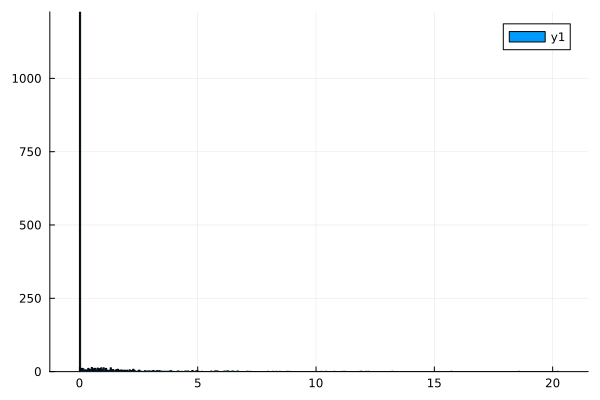

In [49]:
histogram(vec(xi[1:13,:]))

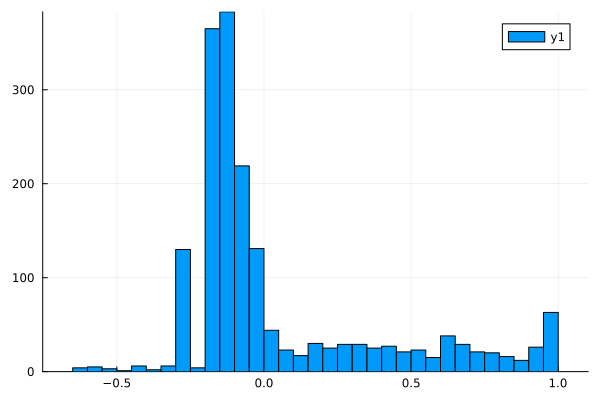

In [50]:
histogram(ys_f |> vec)

In [51]:
yt, _ = model(process_inputs(x, xl), pst, sttf)

([0.010707435419409437 0.014323195060109513 … 0.01580476343517478 0.020133640218575978; 0.3735009530143183 0.2441537661581979 … 0.08062997103114414 0.2545807549534255; 0.002653165128886568 0.22583578513578084 … 0.3583645489693235 0.22508034388316034], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

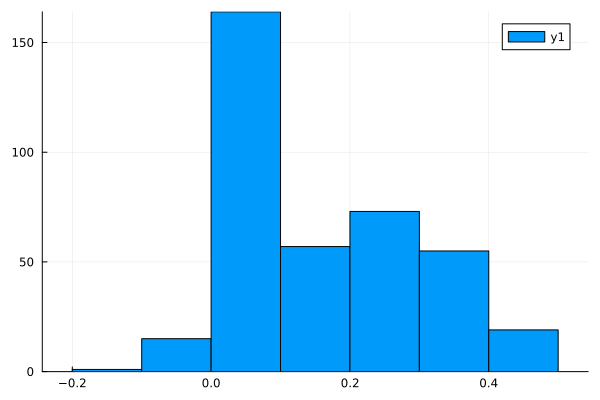

In [52]:
histogram(yt |> vec)

# Calculate the Test Loss

In [53]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [54]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    #predict & correct for zero indexing
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [55]:
yth, _ = model(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst, stt)

([0.018500495137187933 0.024398702615923112 … 0.01845086869115413 0.014348889003471513; -0.028241763939259926 -0.04222739715058013 … -0.0019951798132698205 0.25129444565237324; 0.4012705926611809 0.40981800475961433 … 0.4088387317525437 0.1345254624090824], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [56]:
accuracy(q_test[:,:,:,1:10000], ylocal_test[1:10000], pt_test[1:10000], model, pst, stt, 0.2)

7059

In [57]:
yth |> size

(3, 10000)

In [58]:
labels1 = momentum_to_label(pt_test[1:10000], 0.2)

3×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  1  1     1  ⋅  1  ⋅  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1  1

In [60]:
#OvR_matrices(yth, labels1, 0.0)

In [61]:
using LinearAlgebra: diag

In [62]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [63]:
roc_fn = linear_interpolation(average_duplicate_knots(roc[2], roc[1])...)

20-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 3.370786516853933e-6
 0.0008
 0.0093
 0.0607
 0.1927
 0.3634
 0.5228
 0.6559
 0.7723
 0.85
 0.8921
 0.9181
 0.9891
 0.9946
 0.9981
 0.9992
 0.9996
 0.9997
 0.9997000000000001
 1.0

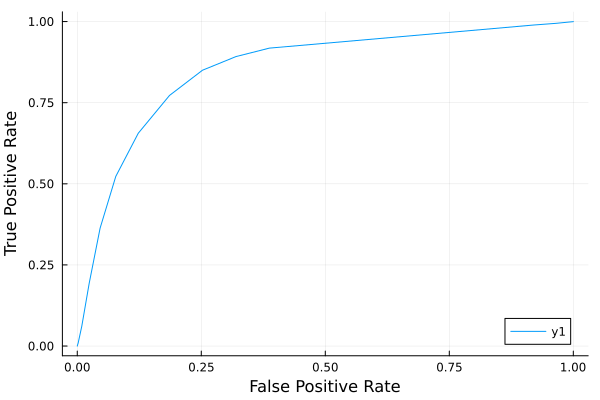

In [64]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [65]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8552480654476802, 1.1867957613112478e-8)

# Build a Spiking Version

In [66]:
sa = SpikingArgs()
repeats = 20

20

In [67]:
mf_spk = Chain(
    LayerNorm((n_in,)),
    x -> tanh.(x),
    MakeSpiking(sa, repeats),
    PhasorDenseF32(n_in => 128),)

Chain(
    layer_1 = LayerNorm((14,), affine=true, dims=Colon()),  # 28 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#55#56"()),
    layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0, 20.0), 0.0),
    layer_4 = PhasorDenseF32((14, 128)),  # 2_048 parameters
)         # Total: 2_076 parameters,
          #        plus 0 states.

In [68]:
model_spk = Chain(
    LayerNorm((n_in,)),
    x -> tanh.(x),
    MakeSpiking(sa, repeats),
    PhasorDenseF32(n_in => 128),
    PhasorDenseF32(128 => 3) 
)

Chain(
    layer_1 = LayerNorm((14,), affine=true, dims=Colon()),  # 28 parameters
    layer_2 = WrappedFunction{:direct_call}(var"#57#58"()),
    layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0, 20.0), 0.0),
    layer_4 = PhasorDenseF32((14, 128)),  # 2_048 parameters
    layer_5 = PhasorDenseF32((128, 3)),  # 390 parameters
)         # Total: 2_466 parameters,
          #        plus 0 states.

In [69]:
function convert_pmlp_params(pmlp_ps)
    # Add a dummy layer of params for the make_spiking layer
    spk_ps = (layer_1 = pmlp_ps.layer_1, 
            layer_2 = pmlp_ps.layer_2,
            layer_3 = NamedTuple(),
            layer_4 = pmlp_ps.layer_3,
            layer_5 = pmlp_ps.layer_4)
    return spk_ps
end      

convert_pmlp_params (generic function with 1 method)

In [70]:
pst_spk = convert_pmlp_params(pst)
sttf_spk = convert_pmlp_params(sttf)

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [71]:
yth_spk, _ = model_spk(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst_spk, sttf_spk)

(SpikingCall(Spike Train: (3, 10000) with 600000 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 20.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [72]:
yth_spk2 = train_to_phase(yth_spk);

In [73]:
size(yth_spk2)

(20, 3, 10000)

In [74]:
size(yth)

(3, 10000)

In [75]:
cycle_correlation(yth, yth_spk2)

20-element Vector{Float64}:
 0.25911735553411613
 0.910120668294238
 0.9548215097849156
 0.9743463235848817
 0.9846610652742263
 0.990374473180276
 0.993750912963832
 0.9955488693874456
 0.996335580364846
 0.9966242250793674
 0.9966174456419279
 0.996440874827586
 0.9961721515779826
 0.9958595598570095
 0.9955327468393181
 0.9952095347857333
 0.994900646002122
 0.99461175287577
 0.9917770587183659
 0.22798149144854116

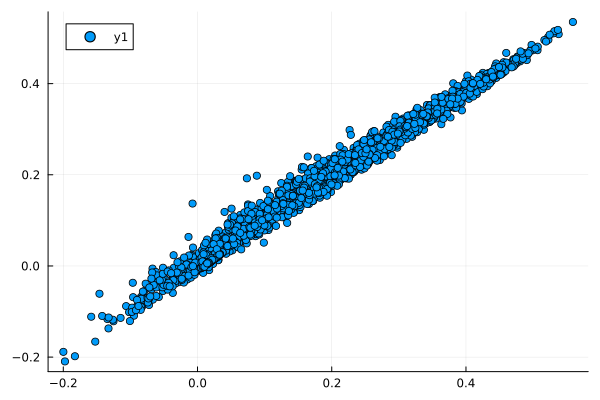

In [76]:
scatter(vec(yth[:,1:1000]), vec(yth_spk2[end-1,:,1:1000]))

In [77]:
roc_spk = tpr_fpr(yth_spk2[end-1,:,:], pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

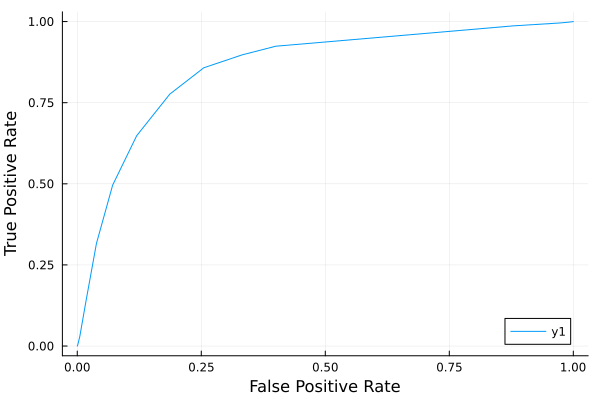

In [78]:
plot(roc_spk[2], roc_spk[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [79]:
roc_spk_fn = linear_interpolation(average_duplicate_knots(roc_spk[2], roc_spk[1])...)

20-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 1.1235955056179776e-5
 0.0003
 0.0038
 0.0295
 0.137
 0.3164
 0.496
 0.6482
 0.7763
 0.8576
 0.8974
 0.924
 0.9867
 0.9956
 0.9981
 0.9992
 0.9996
 0.9998
 0.9998333333333335
 1.0

In [80]:
quadgk(roc_spk_fn, 0.0, 1.0)

(0.8575621205200399, 1.1542662252144534e-8)